In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from src.cleaning import get_types_col
from src.metrics import all_metrics


In [2]:
df_base = pd.read_csv('../data/training_inputs.csv', sep=';', decimal='.')
y = pd.read_csv('../data/training_outputs.csv', sep=';', decimal='.')
df_base = pd.merge(df_base, y, on='ID', how='inner')  

In [3]:
df = df_base.copy()

## 1: Traitement des données

--- 

Première étape pour un projet de data science: Nettoyer les données

In [4]:
df_base["Q66"].unique()

array(['true', 'false', nan, 'true '], dtype=object)

In [5]:
df, types = get_types_col(df)

Premier nettoiement des données et séparation des différents types de variables (qualitatives, quantitatives etc...)

#### Booléennes

In [6]:
df[types[0]].head(5)

,C5,C6,C7,Q7,Q16,Q52,Q53,Q54,Q55,Q56,...,Q70,Q71,Q72,Q73,Q74,Q75,C14,C9,C4,C8
0,False,False,False,False,False,NaN,False,NaN,NaN,NaN,...,True,False,False,NaN,NaN,NaN,True,True,True,True
1,False,False,False,NaN,False,False,True,True,False,True,...,True,False,False,True,False,False,True,True,False,False
2,False,False,False,NaN,False,NaN,False,False,False,True,...,True,False,False,NaN,NaN,NaN,False,True,False,False
3,False,False,False,NaN,True,NaN,False,False,False,False,...,True,False,False,NaN,NaN,NaN,True,True,True,False
4,False,False,False,False,False,NaN,False,NaN,NaN,NaN,...,True,False,False,NaN,NaN,NaN,False,True,True,True


#### Qualitatives

In [7]:
df[types[1]].head(5)

,Q39,Q12,Q1,Q32,Q2,Q36,Q10,C3,C2,C12,C13,Q28,Q3,Q29,Q11,Q34
0,NaN,EA,HA,LC,ZA,AC,PC,C,RA,OB,RC,ZA,UC,IA,D7,ED
1,NaN,E8,HC,LC,ZA,AC,PC,C,RA,OB,RC,ZF,UC,ID,DS,ED
2,NaN,EA,HC,LA,ZA,AD,PD,B,RC,OC,R7,ZF,UA,IA,D3,EF
3,NaN,EA,HC,LD,ZA,AC,PA,C,RA,OA,RC,ZA,UC,IA,DB,ED
4,NaN,EA,HA,LD,ZA,AC,PC,B,RA,OB,RC,ZA,UA,IA,DF,ED


#### Quantitatives

In [8]:
df[types[2]].head(5)

,C10,C11,C15,C16,C17,C18,C19,S1,S2,S8,...,Q42,Q43,Q44,Q45,Q46,Q47,Q48,Q49,Q50,Q51
0,8,2286,2,214,212,16,7,1.0,0,6,...,1.0,0.0,0.0,1.0,1.0,0.0,2.0,1.0,1.0,1.0
1,166,2220,3,511,414,15,19,3.0,2,11,...,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0
2,17,2265,4,407,405,17,8,NaN,0,1,...,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0
3,16,2250,3,712,410,16,12,4.0,1,10,...,0.0,0.0,1.0,1.0,1.0,1.0,3.0,2.0,2.0,3.0
4,23,2305,1,206,204,17,4,NaN,1,1,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0


#### Temporelles

In [9]:
df[types[-1]].head(5)

,S3,S4,S5,S6,S7
0,2013-11-15,2014-02-22,2013-09-08,2013-09-07,2013-09-07
1,2013-11-15,2014-08-07,2013-04-18,2013-09-14,2014-03-21
2,2013-11-15,2013-11-05,2013-11-05,NaT,NaT
3,2013-11-15,2014-05-30,2013-07-03,2014-01-30,2014-05-18
4,2013-11-15,2013-09-22,2013-09-22,NaT,NaT


### Présentation du problème

On cherche à prédire la variable "TARGET", qui contient 20% de 1 (pour 80% de 0)

In [10]:
df["TARGET"].mean()

0.19359515485975518

Il est évident que dans cette configuration, certaines métriques comme l'accuracy ne sont pas très pertinentes

In [11]:
from sklearn.metrics import f1_score, roc_auc_score, classification_report

In [12]:
print(classification_report(df["TARGET"].to_numpy(), [0]*df.shape[0]))

              precision    recall  f1-score   support

       False       0.81      1.00      0.89     68971
        True       0.00      0.00      0.00     16558

    accuracy                           0.81     85529
   macro avg       0.40      0.50      0.45     85529
weighted avg       0.65      0.81      0.72     85529



/home/onyxia/work/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/onyxia/work/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/onyxia/work/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


D'autres métriques telles que le F1 score ou le ROC AUC sont plus pertinentes

In [13]:
roc_auc_score(df["TARGET"].to_numpy(), [0]*df.shape[0])

0.5

In [14]:
float(roc_auc_score(df["TARGET"].to_numpy(), np.random.randint(0, 2, size=df.shape[0])))

0.5025089840271335

In [15]:
f1_score(df["TARGET"].to_numpy(), np.random.randint(0, 2, size=df.shape[0]))

0.27858571932951126

#### Gérer les NAN

Pour les variables catégorielles, on se permet de remplir simplement par "Unknown" les variables avec des NaN

In [16]:
df.fillna({col: "Unknown" for col in types[1]}, inplace=True)
df[types[1]].head(5)

,Q39,Q12,Q1,Q32,Q2,Q36,Q10,C3,C2,C12,C13,Q28,Q3,Q29,Q11,Q34
0,Unknown,EA,HA,LC,ZA,AC,PC,C,RA,OB,RC,ZA,UC,IA,D7,ED
1,Unknown,E8,HC,LC,ZA,AC,PC,C,RA,OB,RC,ZF,UC,ID,DS,ED
2,Unknown,EA,HC,LA,ZA,AD,PD,B,RC,OC,R7,ZF,UA,IA,D3,EF
3,Unknown,EA,HC,LD,ZA,AC,PA,C,RA,OA,RC,ZA,UC,IA,DB,ED
4,Unknown,EA,HA,LD,ZA,AC,PC,B,RA,OB,RC,ZA,UA,IA,DF,ED


In [17]:
list_types = ["Bool", "Qualitative", "Quantitative", "Temporelle"]
to_drop_nan = set()

for cat, list_col in zip(list_types, types):
    if cat == "Qualitative":
        continue

    missing_rate = df[list_col].isna().mean()
    print(cat, "\n", f"Nombre de variables : {len(list_col)}\n", "% de colonnes qui contiennent:\n")
    print(f" Au moins un Nan {len(missing_rate[missing_rate > 0.].index)/len(list_col)}")
    print(f" Au moins 10% de NaN {len(missing_rate[missing_rate > 0.1].index)/len(list_col)}")
    print(f" Au moins 50% de NaN: {len(missing_rate[missing_rate > 0.5].index)/len(list_col)}")
    print(f" Au moins 80% de NaN {len(missing_rate[missing_rate > 0.8].index)/len(list_col)}")

    to_drop_nan.update(missing_rate[missing_rate > 0.6].index)
    
    print('\n', "-"*50, "\n")

print("Colonnes à supprimer:", to_drop_nan)


Bool 
 Nombre de variables : 33
 % de colonnes qui contiennent:

 Au moins un Nan 0.7878787878787878
 Au moins 10% de NaN 0.2727272727272727
 Au moins 50% de NaN: 0.06060606060606061
 Au moins 80% de NaN 0.0

 -------------------------------------------------- 

Quantitative 
 Nombre de variables : 51
 % de colonnes qui contiennent:

 Au moins un Nan 0.7254901960784313
 Au moins 10% de NaN 0.19607843137254902
 Au moins 50% de NaN: 0.13725490196078433
 Au moins 80% de NaN 0.09803921568627451

 -------------------------------------------------- 

Temporelle 
 Nombre de variables : 5
 % de colonnes qui contiennent:

 Au moins un Nan 0.4
 Au moins 10% de NaN 0.4
 Au moins 50% de NaN: 0.0
 Au moins 80% de NaN 0.0

 -------------------------------------------------- 

Colonnes à supprimer: {'Q7', 'Q18', 'Q52', 'Q38', 'Q15', 'Q40', 'Q17', 'Q6', 'Q37'}


La plupart des variables contiennent au moins un NaN mais on voit que la plupart contiennent moins de 10% de NaN

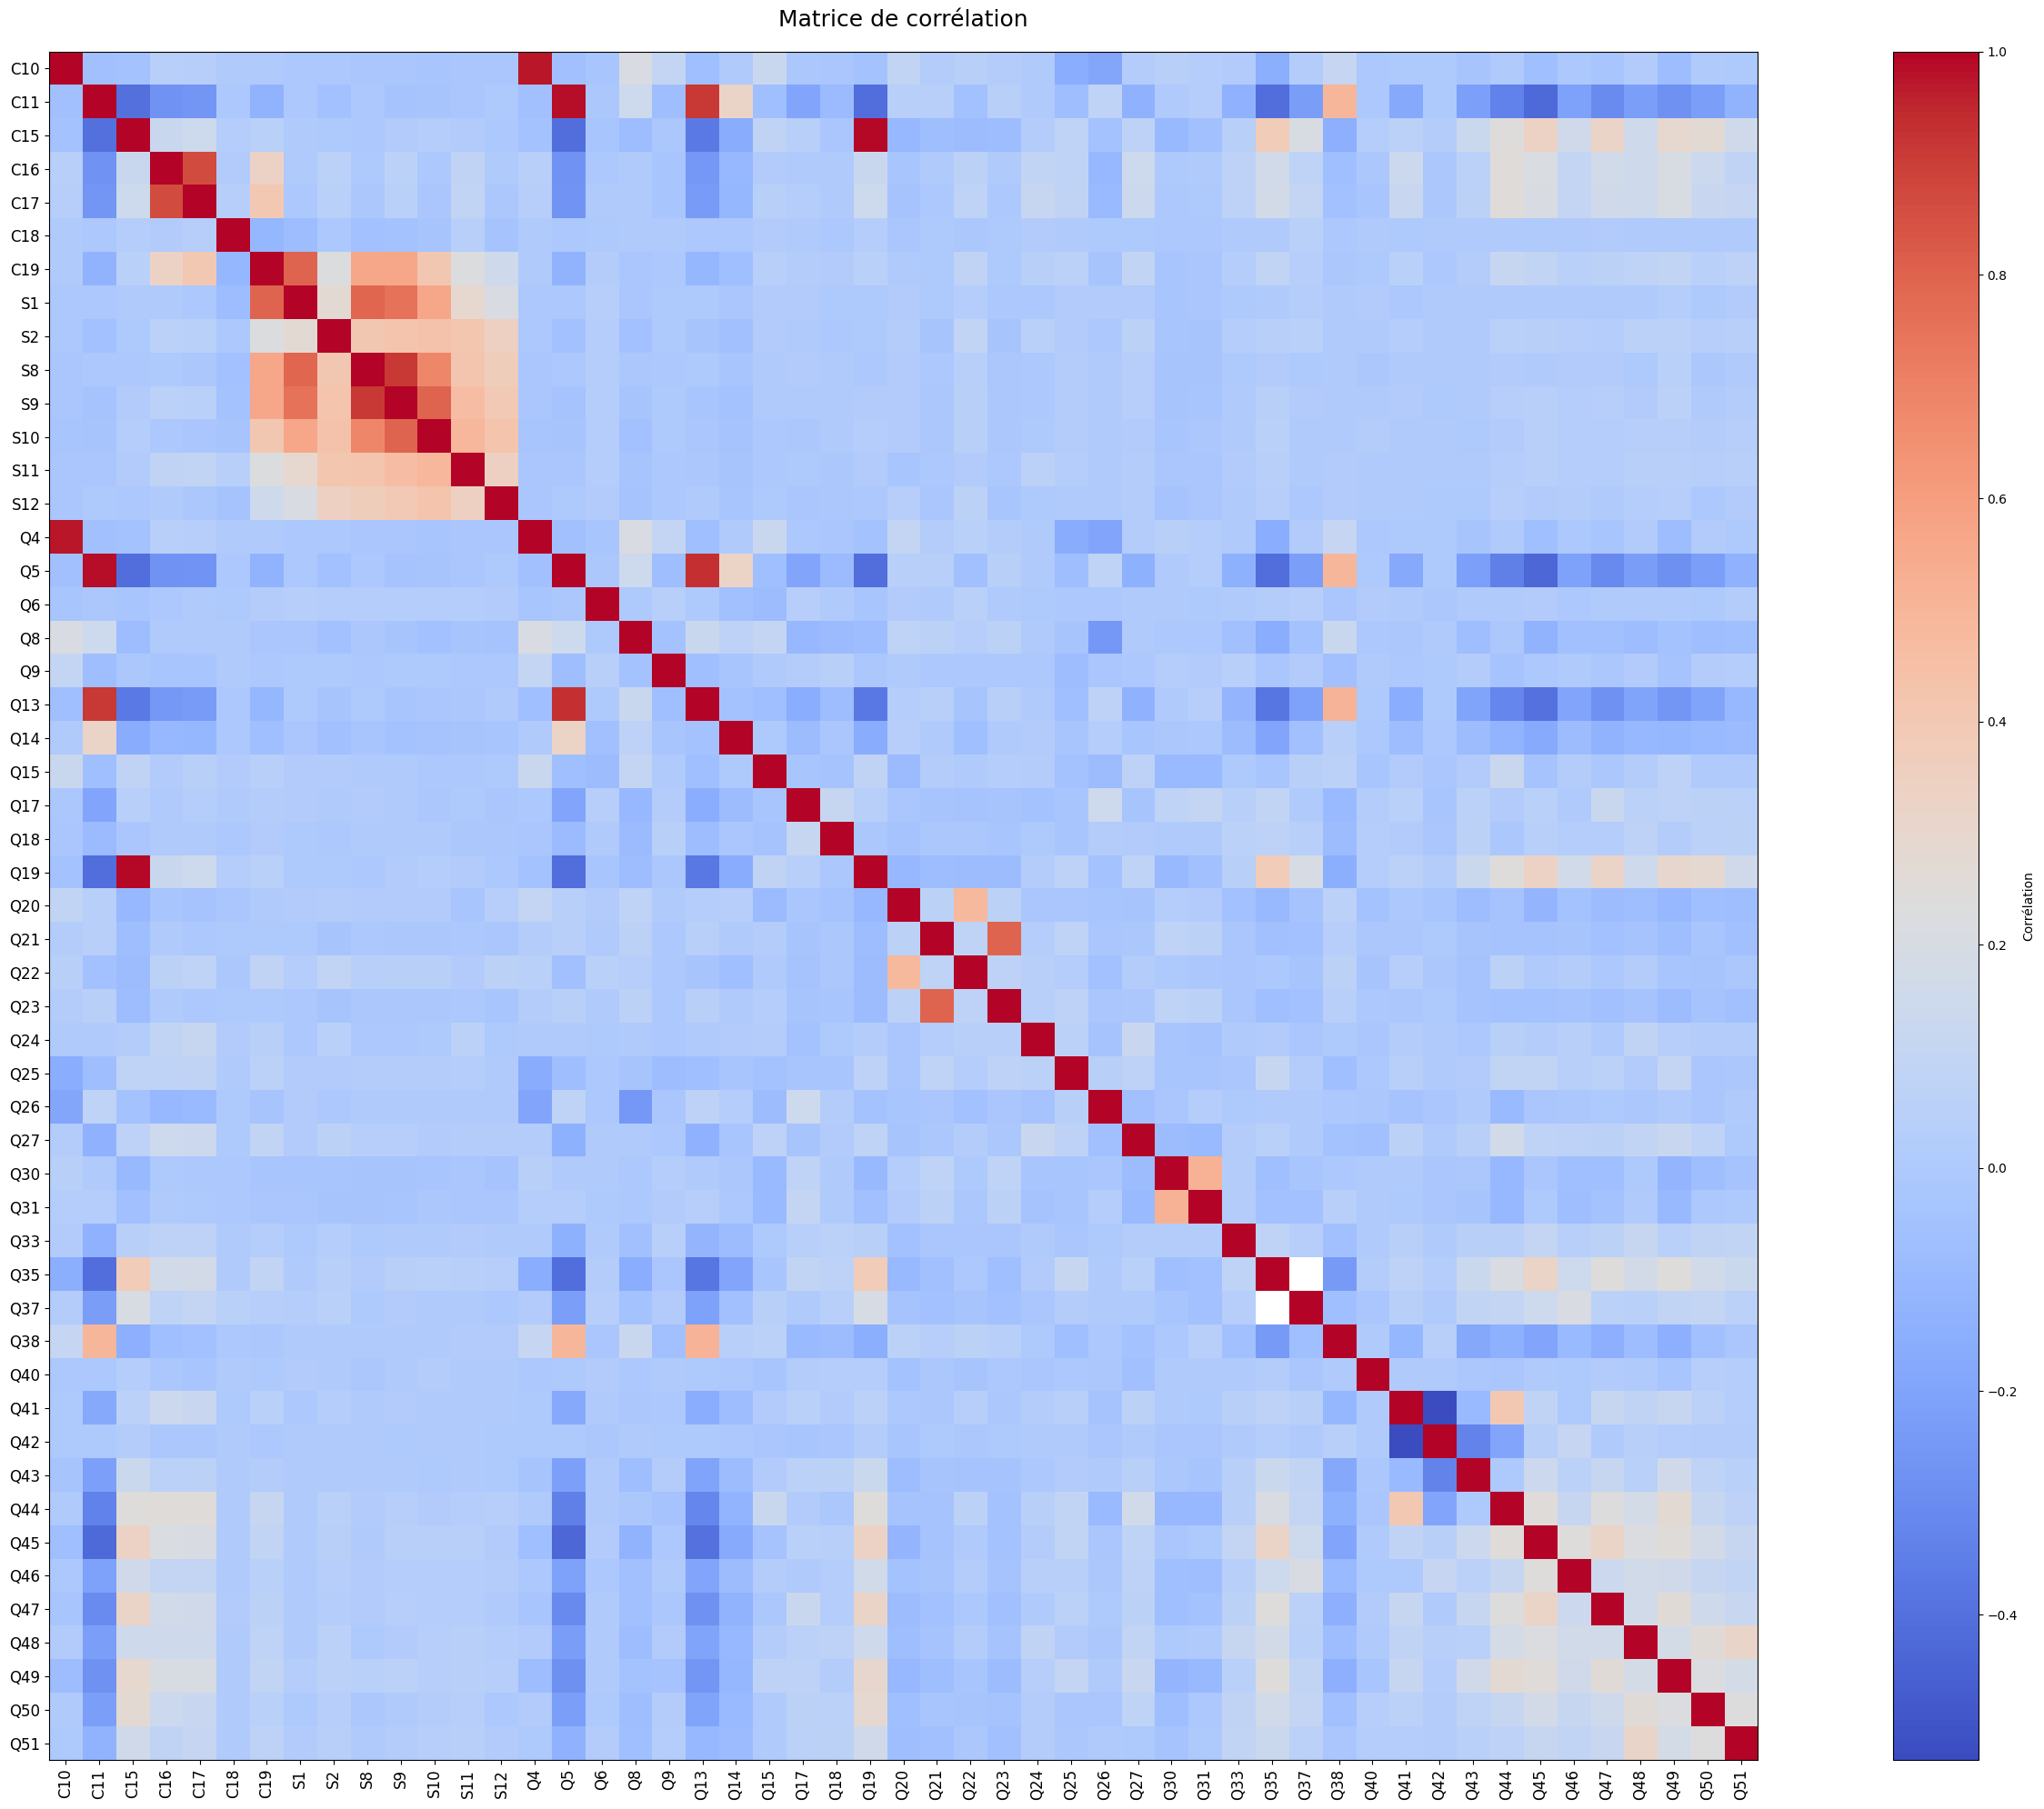

In [18]:
float_vars = df[types[2]]

cov_matrix = float_vars.corr()

plt.figure(figsize=(30, 20))
plt.imshow(cov_matrix, cmap='coolwarm', interpolation='none')
plt.colorbar(label="Corrélation")
plt.title('Matrice de corrélation', pad=20, fontsize=18)

plt.xticks(range(len(cov_matrix.columns)), cov_matrix.columns, rotation=90, fontsize=12)
plt.yticks(range(len(cov_matrix.columns)), cov_matrix.columns, fontsize=12)

plt.tight_layout()
plt.show()

In [19]:
to_drop_corr = set()

for i in range(len(cov_matrix.columns)):
    for j in range(i + 1, len(cov_matrix.columns)):
        if abs(cov_matrix.iloc[i, j]) > 0.8:
            colname_1 = cov_matrix.columns[j]
            colname_2 = cov_matrix.columns[i]
            argmin = np.argmin(np.abs(df[[colname_1, colname_2, "TARGET"]].corr().to_numpy()[-1,:2]))
            colname = colname_1 if argmin==0 else colname_2
            to_drop_corr.add(colname)

print("Colonnes à supprimer pour corrélation > 80% :")
print(to_drop_corr)


Colonnes à supprimer pour corrélation > 80% :
{'C11', 'C15', 'C17', 'S8', 'C10', 'Q13'}


On supprime aussi les variables qualitatives qui ont trop de valeurs différentes (risque d'exploser le nombre de feature car on les converti en OHE). Si les variables avaient un sens plus concret, je déconseillerai cette méthode et je chercherai plutot à créer des variables a partir de celles ci. Mais ici si on a deux variables qui ont 30 valeurs différentes on doit crée 58 dummie ce qui est très élevé

In [20]:
to_drop_uni = set()

for col in types[1]:
    n_unique = df[col].nunique()
    if n_unique>10:
        to_drop_uni.add(col)

print("Colonnes à supprimer (trop de valeurs différentes):")
print(to_drop_uni)      

Colonnes à supprimer (trop de valeurs différentes):
{'Q12', 'Q34', 'Q11', 'Q28'}


In [21]:
for colname in types[-1]:
    df[colname] = df[colname].dt.quarter

In [22]:
import pandas as pd
import numpy as np
from xgboost import XGBClassifier, plot_importance
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification

In [23]:
to_drop_nan

{'Q15', 'Q17', 'Q18', 'Q37', 'Q38', 'Q40', 'Q52', 'Q6', 'Q7'}

In [24]:
to_drop = to_drop_corr.union(to_drop_nan).union(to_drop_uni)

/tmp/ipykernel_33163/1272588805.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scale_pos_weight = y_train.value_counts()[0] / y_train.value_counts()[1]
/home/onyxia/work/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [21:55:05] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


<Figure size 1000x600 with 0 Axes>

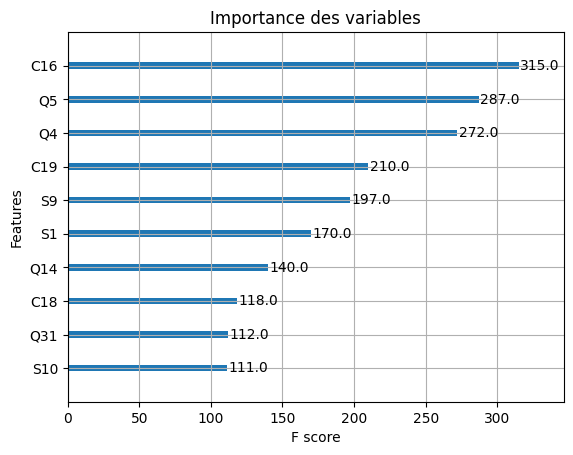

In [45]:
X = df.drop(columns=['TARGET', 'COD_INSEE', 'COD_IRIS', 'ID'])
X = X.drop(to_drop, axis=1)
y = df['TARGET']
X_encoded = pd.get_dummies(X, drop_first=True)

X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, stratify=y, random_state=42)

scale_pos_weight = y_train.value_counts()[0] / y_train.value_counts()[1]

model = XGBClassifier(scale_pos_weight=scale_pos_weight, 
                      objective='binary:logistic', 
                      eval_metric='auc', 
                      use_label_encoder=False,
                      enable_categorical=True)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_pred_prob = model.predict_proba(X_test)[:, 1]

plt.figure(figsize=(10, 6))
plot_importance(model, max_num_features=10, importance_type='weight')
plt.title("Importance des variables")
plt.show()

              precision    recall  f1-score   support

       False       0.88      0.72      0.79     13794
        True       0.34      0.61      0.44      3312

    accuracy                           0.70     17106
   macro avg       0.61      0.66      0.61     17106
weighted avg       0.78      0.70      0.72     17106

AUC: 0.7281
AUPR: 0.3947
FPR95% : 0.7528


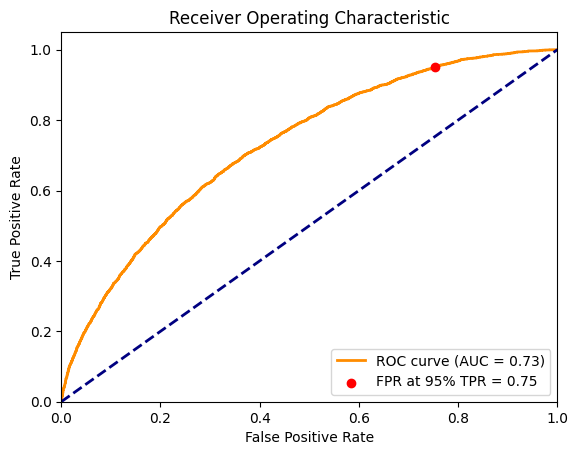

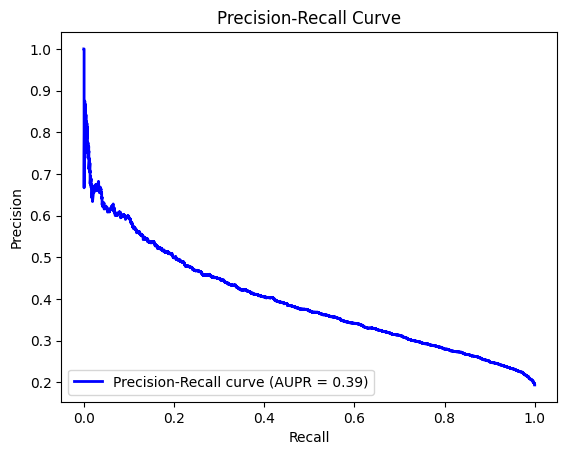

In [46]:
_ = all_metrics(y_test, y_pred_prob, verbose=True)

In [63]:
dft = df.copy()
dft[types[0]] = df[types[0]].fillna(False)

/tmp/ipykernel_33163/384133582.py:2: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  dft[types[0]] = df[types[0]].fillna(False)


/tmp/ipykernel_33163/2167821286.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scale_pos_weight = y_train.value_counts()[0] / y_train.value_counts()[1]
/home/onyxia/work/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [22:00:50] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


              precision    recall  f1-score   support

       False       0.89      0.70      0.78     13794
        True       0.34      0.63      0.44      3312

    accuracy                           0.69     17106
   macro avg       0.61      0.67      0.61     17106
weighted avg       0.78      0.69      0.72     17106

AUC: 0.7344
AUPR: 0.3923
FPR95% : 0.7269


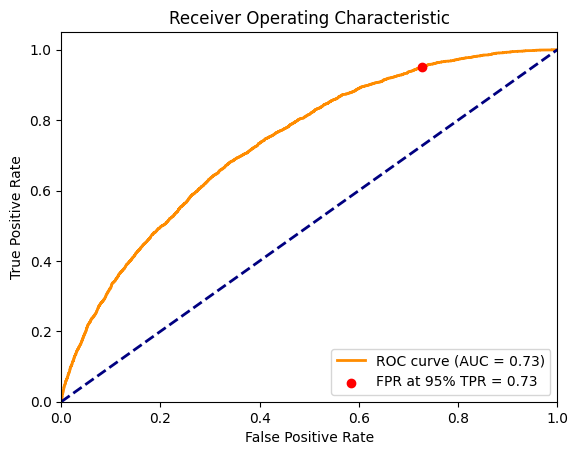

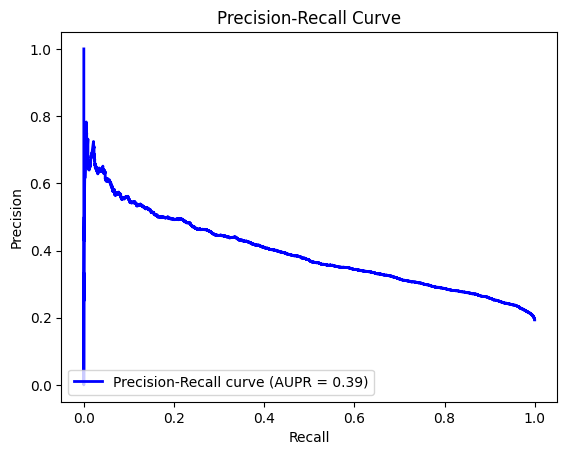

In [64]:
X = dft.drop(columns=['TARGET', 'COD_INSEE', 'COD_IRIS', 'ID'])
X = X.drop(to_drop, axis=1)
y = df['TARGET']
X_encoded = pd.get_dummies(X, drop_first=True)

X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, stratify=y, random_state=42)

scale_pos_weight = y_train.value_counts()[0] / y_train.value_counts()[1]

model = XGBClassifier(#scale_pos_weight=scale_pos_weight, 
                      objective='binary:logistic', 
                      eval_metric='auc', 
                      use_label_encoder=False,
                      enable_categorical=True)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_pred_prob = model.predict_proba(X_test)[:, 1]

_ = all_metrics(y_test, y_pred_prob, verbose=True)

Ici on voit que rajouter le paramètre de "poids" dans XGBoost ne change pas vraiment les résultats (étant donné que je sélectionne après le threshold qui maximise le F1 score)